# SQL and Pandas DataFrames

Google Cloud Datalab allows you to use SQL to interact with Google BigQuery. However, SQL is just the starting point. Datalab enables you to combine the power of declarative SQL with imperative code (Python) to perform interesting data analysis, visualization, and transformation tasks.

You can use a number of Python data analysis, data wrangling, and visualization libraries, such as `numpy`, `pandas`, `matplotlib`, and many others. Several of these libraries build on top of a `DataFrame` object.

This notebook shows how to easily integrate these capabilites together in a single notebook. This functionality is provided by the BigQuery APIs, so the first step is, of course, to import the module along with pandas.

In [4]:
import google.datalab.bigquery as bq
import pandas as pd

# From SQL to DataFrames

In the [BigQuery APIs notebook](http://localhost:8081/notebooks/datalab/docs/tutorials/BigQuery/BigQuery%20APIs.ipynb), we've covered how to define a SQL query, execute it, and get a reference to the results in the form of a `DataFrame`. Let's start with a query to see what more we can do.

In [1]:
%%bq query -n requests
SELECT timestamp, latency, endpoint
FROM `cloud-datalab-samples.httplogs.logs_20140615`
WHERE endpoint = 'Popular' OR endpoint = 'Recent'

In [2]:
%%bq sample --count 5 --query requests

timestamp,latency,endpoint
2014-06-15 07:00:01.973441,21,Popular
2014-06-15 07:00:02.288373,21,Popular
2014-06-15 07:00:01.700211,21,Popular
2014-06-15 07:00:02.043231,21,Popular
2014-06-15 07:00:01.514197,22,Popular


In [5]:
df = requests.execute(output_options=bq.QueryOutput.dataframe()).result()
len(df)

8392

## Data Manipulation

The resulting `DataFrame` can be further transformed, sliced, projected, and inspected using the extensive set of APIs available on the class. Let's print out the first five rows.

In [6]:
df.head(5)

,timestamp,latency,endpoint
0,2014-06-15 19:40:43.414446,256,Recent
1,2014-06-16 03:32:55.519498,256,Recent
2,2014-06-16 01:38:26.398083,256,Recent
3,2014-06-15 17:25:47.865026,256,Recent
4,2014-06-15 14:41:43.465275,256,Recent


Or it can be inspected for schema,

In [7]:
df.dtypes

timestamp    datetime64[ns]
latency               int64
endpoint             object
dtype: object

or further transformed locally, for example to perform grouping,

In [8]:
groups = df.groupby('endpoint')
groups.dtypes

,latency,timestamp
endpoint,,
Popular,int64,NaT
Recent,int64,NaT


In [9]:
for name, df_group in groups:
  print('%s - %d items' % (name, len(df_group)))
  print(df_group.head(3))
  print()

Popular - 7658 items
                     timestamp  latency endpoint
734 2014-06-15 12:32:44.619481      256  Popular
735 2014-06-15 15:33:51.416032      256  Popular
736 2014-06-15 07:11:53.720912      256  Popular

Recent - 734 items
                   timestamp  latency endpoint
0 2014-06-15 19:40:43.414446      256   Recent
1 2014-06-16 03:32:55.519498      256   Recent
2 2014-06-16 01:38:26.398083      256   Recent



and then analyze a dimension per group,

In [10]:
groups['latency'].describe()

endpoint       
Popular   count     7658.000000
          mean       274.439018
          std        187.050788
          min          2.000000
          25%        132.000000
          50%        313.000000
          75%        392.000000
          max       6443.000000
Recent    count      734.000000
          mean       246.268392
          std        690.888990
          min          2.000000
          25%        184.250000
          50%        229.000000
          75%        288.000000
          max      18715.000000
Name: latency, dtype: float64

or even run a set of custom aggregation functions.

In [11]:
def unique(x):
  return sorted(set(list(x)))

groups['latency'].agg({ 'list': lambda x: list(x), 'unique': lambda x: unique(x) })

,unique,list
endpoint,,
Popular,"[2, 3, 4, 5, 6, 7, 8, 9, 11, 15, 19, 20, 21, 2...","[256, 256, 256, 256, 256, 256, 256, 256, 512, ..."
Recent,"[2, 3, 4, 5, 6, 10, 21, 22, 23, 24, 29, 31, 35...","[256, 256, 256, 256, 256, 257, 257, 257, 257, ..."


## Data Visualization

DataFrame provides built-in visualization capabilities using `matplotlib`.

**Conversion to TimeSeries Data**

Our DataFrame instance contains timestamps, latencies, and endpoints. Let's reshape this DataFrame so that each endpoint is a column, that is, an independent series. The timestamp, itself, will be the index row. For timestamps for which one of the endpoints has no data point, we'll use the previous value.

In [16]:
df_series = df.pivot(index='timestamp', columns='endpoint', values='latency').fillna(method = 'backfill')
df_series[10:20]

endpoint,Popular,Recent
timestamp,,
2014-06-15 07:00:20.649279,177.0,427.0
2014-06-15 07:00:54.666471,352.0,427.0
2014-06-15 07:01:28.139716,471.0,427.0
2014-06-15 07:01:33.672656,394.0,427.0
2014-06-15 07:01:37.050927,321.0,427.0
2014-06-15 07:02:21.453438,390.0,427.0
2014-06-15 07:02:31.533299,390.0,331.0
2014-06-15 07:02:51.365249,130.0,331.0
2014-06-15 07:02:57.402798,121.0,331.0


In [13]:
len(df_series)

8392

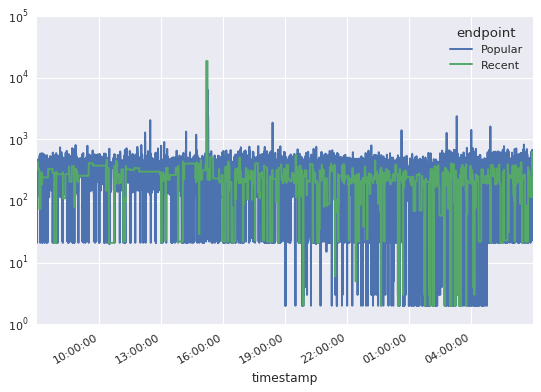

In [20]:
df_series.plot(logy = True)

**Resampling**

The plot above is not meaningful. Our time-series data is taken arbitrary timestamps, whenever a request was processed. It is irregularly spaced, and there are a large number of data points. DataFrames provide the ability to resample a time-series into more meaningful time windows.

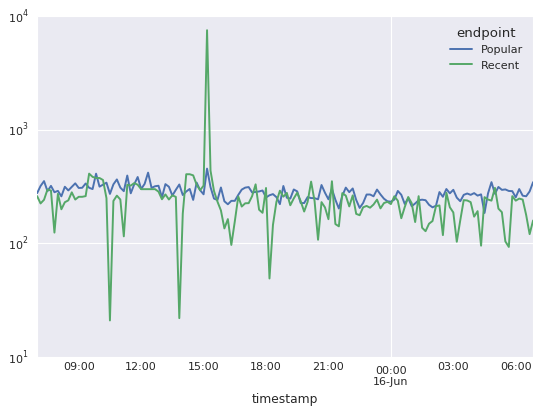

In [21]:
df_series.resample(rule='10min').mean().plot(logy = True)

# Looking Ahead

Python pandas provide an extensive toolbox of capabilities for working with data. Datalab combines the power of BigQuery and DataFrames.

Subsequent notebooks cover additional SQL capabilities that you to use the full power of BigQuery, allowing you to run queries close to your entire dataset before bringing a useful subset of data into the notebook.